# Drug Targeting different nodes of the 524 cascade system

## Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'\src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [3]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import *

import matplotlib.pyplot as plt
import seaborn as sns
import roadrunner
import numpy as np
import pandas as pd

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

In [12]:
import os 

### parameters 

notebook_name = 'SISO_Drug_Model'
plot_figures = True
run_jobs = False
parallelise = True
save_figures = True

## Generation of ground truth model 

model_name = 'v3_small_model_52'
o_random_seed = 4
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (5, 5000)
param_range = (0.1, 10)
param_multiplier_range = (0.7, 1.3)


## Simulation parameters 

simulation_time = 1500
simulation_step = 100

## Feature data generation 

feature_generation_method = 'uniform'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed
''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

## General parameters 
experiment_id = notebook_name + '_' + str(o_random_seed) + '_' + str(feature_generation_seed)
experiment_folder = config['DATA_PATH'] + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)
    
print(experiment_folder)

G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/SISO_Drug_Model_4_50/


## Jobs and Visualisations

### Generate drug network

In [5]:
from models.Utils import *
from models.DrugModelSpecification import DrugModelSpecification, Drug

model_drug_spec = DrugModelSpecification()
model_drug_spec.generate_specifications(4, 5, 2, verbose=0)
G0_d = model_drug_spec.generate_network('drug_model_524', specie_value_range, param_range, param_multiplier_range, random_seed=4, verbose=0)

In [6]:
print(model_drug_spec.get_feedback_regulations())

[(('C', 'A1'), 'up'), (('B0', 'A2'), 'down')]


In [7]:
def modified_drug_spec_SY(original_spec: ModelSpecification): 
    spec = deepcopy(original_spec)
    added_regulations = [('C', 'A3'), ('B2', 'A4'), ('B1', 'A0'), ('B3', 'A2')]
    added_reg_types = ['down', 'down', 'up', 'up']
    for i, reg in enumerate(added_regulations):
        spec.add_regulation(reg, added_reg_types[i])
    return spec

In [8]:
modded_spec = modified_drug_spec_SY(model_drug_spec)
print(modded_spec.get_feedback_regulations())

[(('C', 'A1'), 'up'), (('B0', 'A2'), 'down'), (('C', 'A3'), 'down'), (('B2', 'A4'), 'down'), (('B1', 'A0'), 'up'), (('B3', 'A2'), 'up')]


In [9]:
# create a drug which targets all of the A species
drug_all_Ad = Drug('DAd', 500, 5000) 
drug_all_Ad.add_regulation('A0', 'down')
drug_all_Ad.add_regulation('A1', 'down')
drug_all_Ad.add_regulation('A2', 'down')
drug_all_Ad.add_regulation('A3', 'down')
drug_all_Ad.add_regulation('A4', 'down')

drug_all_Au = Drug('DAu', 500, 5000)
drug_all_Au.add_regulation('A0', 'up')
drug_all_Au.add_regulation('A1', 'up')
drug_all_Au.add_regulation('A2', 'up')
drug_all_Au.add_regulation('A3', 'up')
drug_all_Au.add_regulation('A4', 'up')

possible_drugs = [drug_all_Ad, drug_all_Au] 

In [10]:
diff_model_specs = []
diff_models = []
model_labels = []
for drug in possible_drugs:
    new_drug_spec = DrugModelSpecification()
    new_drug_spec.generate_specifications(4, 5, 2, verbose=0)
    new_drug_spec.add_drug(drug)
    new_model = new_drug_spec.generate_network(f'drug_model_524_{drug.name}', specie_value_range, param_range, param_multiplier_range, random_seed=4, verbose=0)
    new_model = copy_over_params_states(G0_d, new_model)
    label = f'{drug.name}'
    diff_model_specs.append(new_drug_spec)
    diff_models.append(new_model)
    model_labels.append(label)
    
    new_drug_spec = modified_drug_spec_SY(new_drug_spec)
    new_model = new_drug_spec.generate_network(f'drug_model_524_{drug.name}_SY', specie_value_range, param_range, param_multiplier_range, random_seed=4, verbose=0)
    new_model = copy_over_params_states(G0_d, new_model)
    label = f'{drug.name}_SY'
    diff_model_specs.append(new_drug_spec)
    diff_models.append(new_model)
    model_labels.append(label)

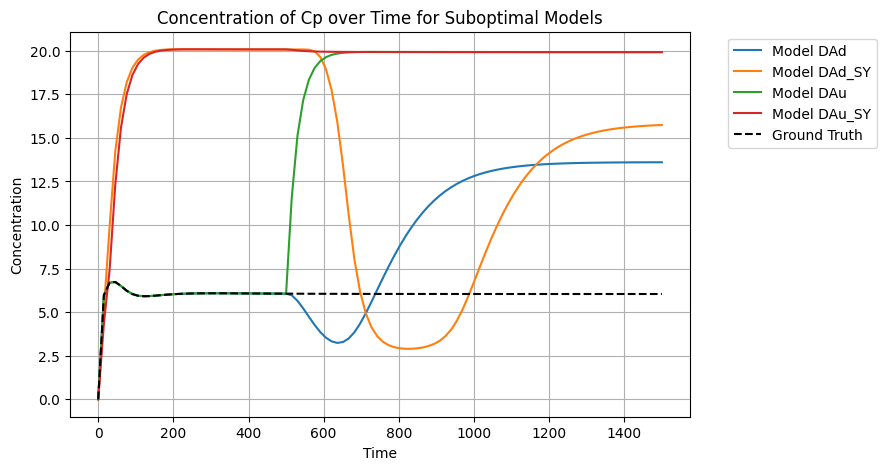

In [13]:
# perform simulations on each of the models 
import matplotlib.pyplot as plt
import seaborn as sns
import roadrunner
import numpy as np
import pandas as pd

if plot_figures:
    # Visualise the behaviour of the suboptimal models, plot the original model as reference comparison
    plt.figure(figsize=(8, 5))

    for i, s_model in enumerate(diff_models):
        runner = roadrunner.RoadRunner(s_model.get_sbml_model())
        res = runner.simulate(0, simulation_time, simulation_step)
        plt.plot(res['time'], res['[Cp]'], label=f"Model {model_labels[i]}")
        
    runner = roadrunner.RoadRunner(G0_d.get_sbml_model())
    res = runner.simulate(0, simulation_time, simulation_step)
    plt.plot(res['time'], res['[Cp]'], label="Ground Truth", linestyle='dashed', color='black')
        
    plt.xlabel("Time")
    plt.ylabel("Concentration")
    plt.title("Concentration of Cp over Time for Suboptimal Models")
    plt.grid(True)
    # set the legend to be outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

## Synthetic data for each model

In [ ]:
### Generate the synthetic data
feature_df_sets = []
initial_value_sets = []
target_df_sets = []
time_course_data_sets = []

for i, model_spec in enumerate(diff_model_specs): 
    model = diff_models[i]
    runner = roadrunner.RoadRunner(model.get_sbml_model())
    feature_df = generate_feature_data(model_spec, runner, feature_generation_method, feature_generation_extra_params, feature_generation_size, seed=feature_generation_seed)
    initial_values = get_model_initial_values(model_spec, runner)
    target_df, time_course_data = generate_target_data(model_spec, runner, feature_df, initial_values)
    feature_df_sets.append(feature_df)
    initial_value_sets.append(initial_values)
    target_df_sets.append(target_df)
    time_course_data_sets.append(time_course_data)

## Generate suboptimal models

In [17]:
n_sub = 10
suboptimal_models_rms = []
suboptimal_models_spec_rms = []
suboptimal_models_labels = []
n_edge_removed_range = (2,9)

for i, model_spec in enumerate(diff_model_specs):
    model = diff_models[i]
    for n_edge_removed in range(n_edge_removed_range[0], n_edge_removed_range[1]+1):
        for j in range(n_sub):
            s_spec, s_model = systematic_edge_pruning(model_spec, model, n_edge_removed, random_seed=j)
            suboptimal_models_spec_rms.append(s_spec)
            suboptimal_models_rms.append(s_model)
            suboptimal_models_labels.append(f'{model_labels[i]}_{n_edge_removed}_{j}')

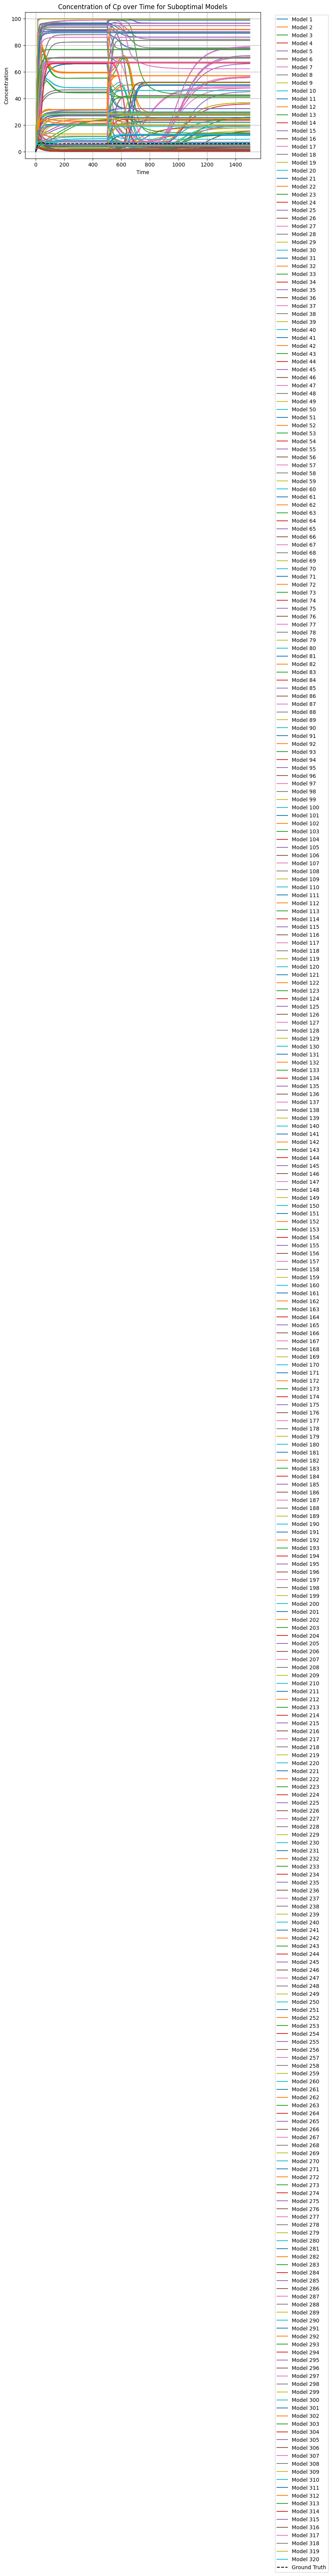

In [ ]:
if plot_figures:
    # Visualise the behaviour of the suboptimal models, plot the original model as reference comparison
    plt.figure(figsize=(8, 5))

    for i, s_model in enumerate(suboptimal_models_rms):
        runner = roadrunner.RoadRunner(s_model.get_sbml_model())
        res = runner.simulate(0, simulation_time, simulation_step)
        plt.plot(res['time'], res['[Cp]'], label=f"Model {i+1}")
        
    runner = roadrunner.RoadRunner(G0_d.get_sbml_model())
    res = runner.simulate(0, simulation_time, simulation_step)
    plt.plot(res['time'], res['[Cp]'], label="Ground Truth", linestyle='dashed', color='black')
        
    plt.xlabel("Time")
    plt.ylabel("Concentration")
    plt.title("Concentration of Cp over Time for Suboptimal Models")
    plt.grid(True)
    # set the legend to be outside the plot
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()